<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/StockPrediction/blob/main/Capstone_GOOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsforecast keras-tuner yfinance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.3 MB/s eta 0:00:00


In [2]:
# Standard Libraries
import warnings
from datetime import datetime, timedelta

# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Finance Data
import yfinance as yf

# Statsmodels - Time Series & Statistical Tests
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera

# Scipy
from scipy.stats import t, probplot

# Forecasting Libraries
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Scikit-learn - Metrics & Preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# TensorFlow / Keras - Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Keras Tuner
import keras_tuner as kt  # You may need: pip install keras-tuner

#SVM
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


# Suppress warnings
warnings.filterwarnings("ignore")


In [3]:
# # Acquire data from yfinance

# symbol = 'GOOG'

# df = yf.download(symbol, period="max", interval="1d")
# df.to_csv("GOOG.csv")

In [4]:
GOOG = pd.read_csv("https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/GOOG.csv")
GOOG = GOOG[2:]
GOOG = GOOG.reset_index()
GOOG = GOOG.drop(columns=["index"])
GOOG = GOOG.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
GOOG[columns_to_convert] = GOOG[columns_to_convert].astype(float)
GOOG['Date'] = pd.to_datetime(GOOG['Date'])
GOOG['Volume'] = GOOG['Volume'].astype(int)
GOOG.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [5]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5186 non-null   datetime64[ns]
 1   Close   5186 non-null   float64       
 2   High    5186 non-null   float64       
 3   Low     5186 non-null   float64       
 4   Open    5186 non-null   float64       
 5   Volume  5186 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 243.2 KB


In [6]:
df = GOOG[(GOOG['Date'] >= datetime(2020, 1, 1)) & (GOOG['Date'] <= datetime(2025, 1, 31))].reset_index(drop=True)
# df = GOOG[GOOG['Date'] >= datetime.datetime(2020, 1, 1)].reset_index(drop=True)

prices = df[['Close','Date']]
prices = prices.set_index('Date')

actual = GOOG[GOOG['Date']> datetime(2025, 1, 31)].reset_index(drop=True)

In [7]:
len(actual), len(df), len(GOOG)

(39, 1278, 5186)

### EDA

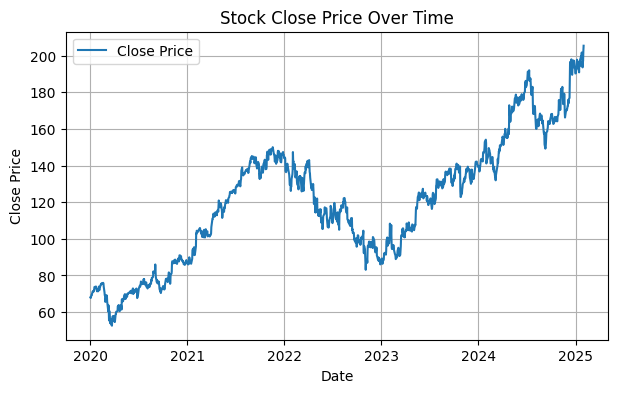

In [8]:
# Plot the Close price
plt.figure(figsize=(7, 4))
plt.plot(prices, label="Close Price")

# Chart formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### ARIMA

Hypothesis testing:

null hypothesis: The stock is stationary

In [9]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=prices['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is -0.45
The p value is 0.90


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

In [10]:
from statsmodels.tsa.stattools import acf, pacf

#identifying p
x_acf = acf(prices['Close'], nlags = 40)
filtered_values = x_acf[x_acf > 0.95]
print("Based on acf we can identify p value as :",len(filtered_values))

Based on acf we can identify p value as : 11


In [11]:
x_pacf = pacf(prices)
x_pacf

array([ 1.00000000e+00,  9.95016174e-01,  2.09066908e-02,  4.75658742e-02,
        2.87896211e-02,  2.37973321e-02, -3.18166425e-02,  2.06084860e-02,
       -1.69951375e-02, -5.50605048e-03, -1.85534405e-02,  2.11750002e-02,
       -1.92076756e-02,  5.99794859e-02, -3.21860818e-04,  8.01047028e-03,
        6.33769817e-03, -1.66642682e-02,  2.51794798e-03,  2.04507984e-03,
        2.64073282e-02,  9.20342954e-03, -1.44617115e-03,  4.09490410e-03,
       -1.72737766e-02, -3.17580780e-02, -8.13122447e-03,  2.06374539e-02,
        9.51879373e-03, -5.33316582e-03, -3.99844853e-02,  1.79691870e-02])

Based on the pacf value we are identifying the pacf value as 1

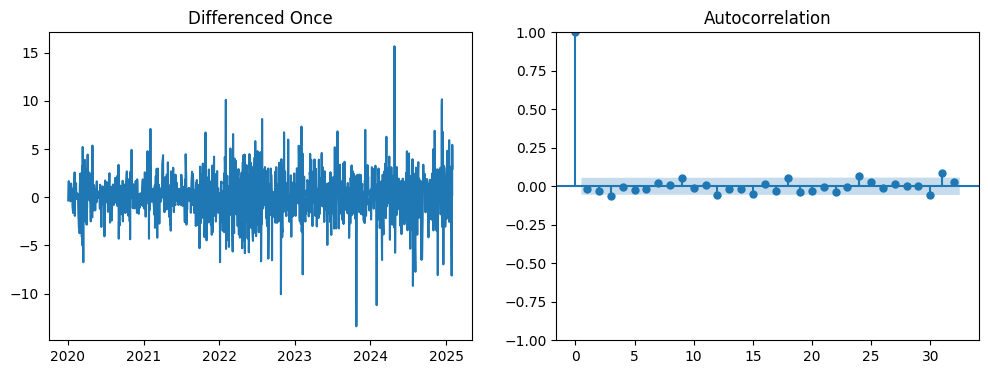

In [12]:
diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);

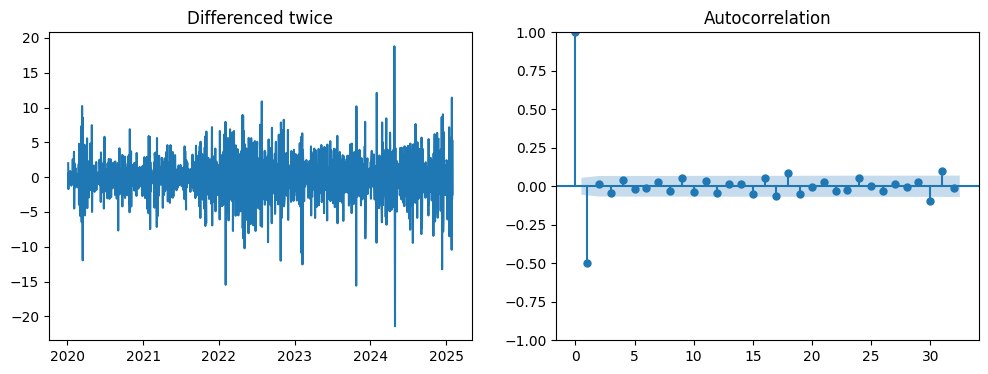

In [13]:
diff = prices.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff,ax=ax2);

Based on differentiation we identify the d as 1

In [14]:
modelpredictions = []

In [15]:
training_data = list(prices['Close'])

In [16]:
for i in range(len(actual)):
  model = ARIMA(training_data, order=(11,1,1))
  model_fit = model.fit()
  forecast = model_fit.forecast()
  yhat = list(forecast)[0]
  modelpredictions.append(yhat)
  actual_test = list(actual['Close'])[i]
  training_data.append(actual_test)

In [17]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1316
Model:                ARIMA(11, 1, 1)   Log Likelihood               -3009.652
Date:                Fri, 11 Apr 2025   AIC                           6045.304
Time:                        05:48:00   BIC                           6112.665
Sample:                             0   HQIC                          6070.564
                               - 1316                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6059      0.409     -1.482      0.138      -1.407       0.195
ar.L2         -0.0348      0.034     -1.031      0.302      -0.101       0.031
ar.L3         -0.0623      0.030     -2.080      0.0

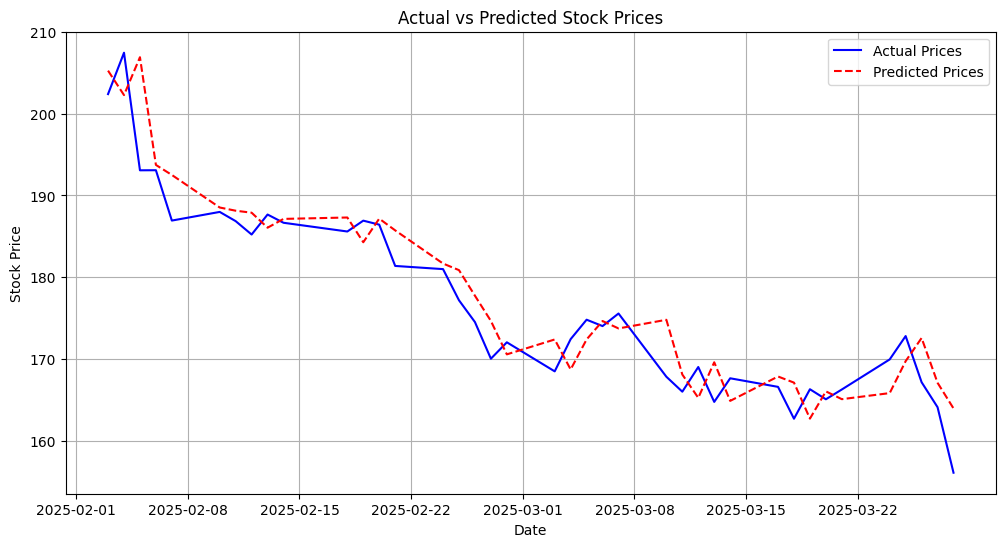

In [18]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [19]:
rmse = np.sqrt(mean_squared_error(actual['Close'], modelpredictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 4.0754


In [20]:
r2_score(actual['Close'], modelpredictions)

0.8737283225381282

### Auto Arima

In [21]:
%%capture
!pip install pmdarima
!pip install "numpy<2"

In [22]:
prices.head()

,Close
Date,
2020-01-02,68.046196
2020-01-03,67.712273
2020-01-06,69.381874
2020-01-07,69.338585
2020-01-08,69.884987


In [23]:
tilljan = GOOG[(GOOG['Date'] <= '2025-01-31')]
tilljan.tail()

,Date,Close,High,Low,Open,Volume
5142,2025-01-27,193.549500,198.443917,192.480710,193.969020,24970200
5143,2025-01-28,196.845749,197.005555,192.390818,194.428489,15939200
5144,2025-01-29,196.955612,198.234170,194.967886,197.145398,12287800
5145,2025-01-30,202.399414,203.006724,199.245003,199.532670,14571500
5146,2025-01-31,205.366043,206.844355,203.348337,203.483178,17087300


In [24]:

# from pmdarima.arima import auto_arima

# model = auto_arima(tilljan['Close'], seasonal=True, start_p=1, max_p=13, start_q=1, max_q=2, m=12, start_P= 0, trace=True, d = 1, D=1, error_action='ignore', suppress_warnings=True)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

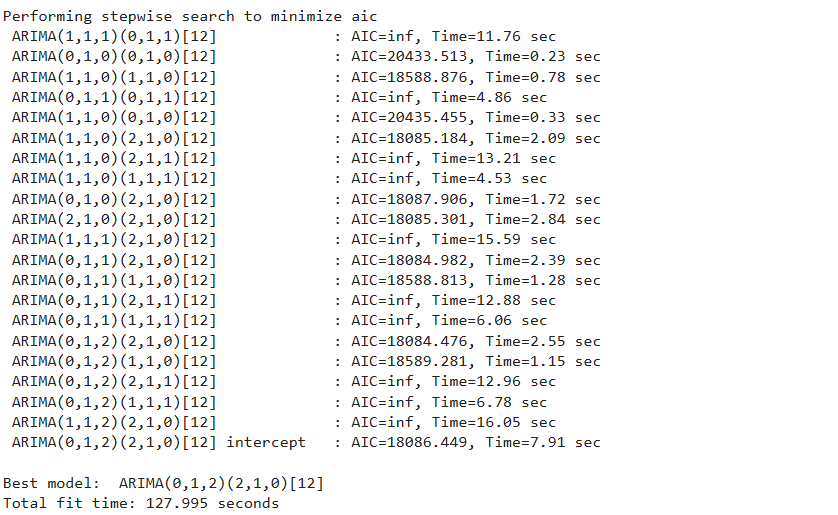

In [ ]:
# model.summary()

### LSTM

In [25]:
GOOG

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512
...,...,...,...,...,...,...
5181,2025-03-24,169.929993,170.500000,167.440002,169.264999,18742800
5182,2025-03-25,172.789993,172.910004,170.550003,171.179993,13841600
5183,2025-03-26,167.139999,171.940002,166.860992,171.300003,22554200
5184,2025-03-27,164.080002,167.440002,163.850006,166.710007,21571200


In [26]:
temp = GOOG
temp.set_index("Date", inplace=True)
temp.head()

,Close,High,Low,Open,Volume
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [27]:
features_to_use = ['Open', 'High', 'Low', 'Volume']
target_col = 'Close'

# Select final data
all_cols = features_to_use + ([target_col] if target_col not in features_to_use else [])
data_final = temp[all_cols].copy()

print("Data head with features:")
print(data_final.head())

Data head with features:
                Open      High       Low     Volume     Close
Date                                                         
2004-08-19  2.478923  2.579567  2.378775  897427216  2.487352
2004-08-20  2.503960  2.704009  2.491318  458857488  2.684922
2004-08-23  2.745407  2.813082  2.703266  366857939  2.711942
2004-08-24  2.757554  2.766478  2.567421  306396159  2.599647
2004-08-25  2.601877  2.677237  2.575105  184645512  2.627658


In [28]:
# Scale features and target separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [29]:
# Sort data by date just in case it's not
data_final.sort_index(inplace=True)

scaled_features = feature_scaler.fit_transform(data_final[features_to_use])

# Scale target
# Reshape target to be 2D array for scaler
scaled_target = target_scaler.fit_transform(data_final[[target_col]])

In [30]:
def create_dataset(X_data, y_data, time_step=60):
    Xs, ys = [], []
    # We need data up to index i + time_step for y, so loop ends earlier
    for i in range(len(X_data) - time_step):
        v = X_data[i:(i + time_step)]
        Xs.append(v)
        ys.append(y_data[i + time_step]) # Predict the day *after* the sequence ends
    return np.array(Xs), np.array(ys)

TIME_STEP = 60 # Lookback window
X, y = create_dataset(scaled_features, scaled_target, TIME_STEP)


In [31]:
# Define the split date for Train/Test
split_date_str = "2025-01-31" # Data *before* this is train, *on or after* is test
split_date = pd.to_datetime(split_date_str)
split_date

Timestamp('2025-01-31 00:00:00')

In [32]:
original_indices_for_y = data_final.index[TIME_STEP:]
original_indices_for_y

DatetimeIndex(['2004-11-12', '2004-11-15', '2004-11-16', '2004-11-17',
               '2004-11-18', '2004-11-19', '2004-11-22', '2004-11-23',
               '2004-11-24', '2004-11-26',
               ...
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
               '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28'],
              dtype='datetime64[ns]', name='Date', length=5126, freq=None)

In [33]:
split_point_sequences = np.where(original_indices_for_y >= split_date)[0][0]

In [34]:
np.where(original_indices_for_y >= split_date)

(array([5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096,
        5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107,
        5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118,
        5119, 5120, 5121, 5122, 5123, 5124, 5125]),)

In [35]:
validation_split_fraction = 0.15 # Use 15% of the data *before* the test split for validation
val_size = int(split_point_sequences * validation_split_fraction)

# if val_size == 0 and split_point_sequences > 1 : # Ensure val_size is at least 1 if possible
#     val_size = 1

train_size = split_point_sequences - val_size


In [36]:
# Perform the splits
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:split_point_sequences], y[train_size:split_point_sequences]
X_test, y_test = X[split_point_sequences:], y[split_point_sequences:]
# Keep track of the actual dates for the test set targets for comparison later
test_dates = original_indices_for_y[split_point_sequences:]

In [37]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4324, 60, 4), (4324, 1), (762, 60, 4), (762, 1), (40, 60, 4), (40, 1))

In [42]:
import os
import requests
import json

In [45]:
# --- 5. Model Building Function for Keras Tuner ---
def build_model(hp):
    model = Sequential()

    # Tune the number of LSTM units in the first layer
    # Choose a range (e.g., 32-256 units), step size 32
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=hp_units_1, return_sequences=True, # return_sequences=True if next layer is LSTM
                    input_shape=(X_train.shape[1], X_train.shape[2]))) # (time_steps, num_features)
    # Tune dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))

    # --- Optional: Add more LSTM layers ---
    # Tune whether to have a second LSTM layer
    if hp.Boolean("add_second_lstm_layer"):
        hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
        # return_sequences=False if the next layer is Dense
        model.add(LSTM(units=hp_units_2, return_sequences=False))
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(hp_dropout_2))
    else:
        # If only one LSTM layer, make sure it doesn't return sequences
        # We need to rebuild the first layer definition slightly differently
        model = Sequential() # Start over for simplicity in this example structure
        model.add(LSTM(units=hp_units_1, return_sequences=False, # Set to False now
                         input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(hp_dropout_1))
    # --- End Optional Section ---


    # Output layer
    model.add(Dense(units=1)) # Predicting one value

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error', # Common for regression
                  metrics=['mean_absolute_error']) # Easier to interpret than MSE
    return model

try:
  url = 'https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/bestparam.json'
  response = requests.get(url)
  response.raise_for_status()
  best_hps = response.json()
except:
  # --- 6. Instantiate the Tuner ---
  # Hyperband is an efficient tuner
  tuner = kt.Hyperband(build_model,
                      objective='val_mean_absolute_error', # Minimize validation MAE
                      max_epochs=50, # Max epochs *per trial* in Hyperband
                      factor=3, # Reduction factor for candidates per bracket
                      directory='keras_tuner_dir', # Directory to store results
                      project_name='googl_stock_lstm',
                      overwrite=False) # Set overwrite to False to resume

  # Optional: Add EarlyStopping callback *during tuning*
  # This stops training a specific trial early if validation loss doesn't improve
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # --- 7. Run the Hyperparameter Search (Conditional Execution) ---
  search_already_run = os.path.exists(os.path.join('keras_tuner_dir', 'googl_stock_lstm', 'project.json'))

  if not search_already_run:
      print("\nStarting hyperparameter search...")
      # Note: Use validation data here for the tuner to evaluate configurations
      # The number of epochs here is the max per trial for Hyperband internal loops
      tuner.search(X_train, y_train,
                  epochs=50, # This refers to max_epochs for Hyperband trials
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping],
                  batch_size=32) # You can also tune batch_size if desired
  else:
      print("\nHyperparameter search already completed or found existing results.")
      print("Loading previous search results...")
      try:
          best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

          print(f"""
          The hyperparameter search is complete.
          Optimal number of units in first LSTM layer: {best_hps.get('units_1')}
          Optimal dropout rate for first layer: {best_hps.get('dropout_1')}
          Optimal learning rate: {best_hps.get('learning_rate')}
          Include second LSTM layer: {best_hps.get('add_second_lstm_layer')}
          """)

          if best_hps.get('add_second_lstm_layer'):
              print(f"Optimal number of units in second LSTM layer: {best_hps.get('units_2')}")
              print(f"Optimal dropout rate for second layer: {best_hps.get('dropout_2')}")
      except Exception as e:
          print(f"Error loading previous results: {e}")
          print("Please ensure the 'keras_tuner_dir/googl_stock_lstm' directory exists and contains valid tuner data.")
          print("You might need to run the search again if the previous run was incomplete or corrupted.")

  # --- 8. Get the Optimal Hyperparameters ---
  if not search_already_run:
      best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

      print(f"""
      The hyperparameter search is complete.
      Optimal number of units in first LSTM layer: {best_hps.get('units_1')}
      Optimal dropout rate for first layer: {best_hps.get('dropout_1')}
      Optimal learning rate: {best_hps.get('learning_rate')}
      Include second LSTM layer: {best_hps.get('add_second_lstm_layer')}
      """)

      if best_hps.get('add_second_lstm_layer'):
          print(f"Optimal number of units in second LSTM layer: {best_hps.get('units_2')}")
          print(f"Optimal dropout rate for second layer: {best_hps.get('dropout_2')}")

In [46]:
# # best model values stored as file

# import json

# with open("bestparam.json", 'w') as f:
#         json.dump(best_hps.values, f, indent=4)

In [47]:
# Extract the values into a dictionary
best_params = {
    'units_1': best_hps.get('units_1'),
    'dropout_1': best_hps.get('dropout_1'),
    'learning_rate': best_hps.get('learning_rate'),
    'add_second_lstm_layer': best_hps.get('add_second_lstm_layer'),
    # Add other tuned parameters here...
}
if best_params['add_second_lstm_layer']:
     best_params['units_2'] = best_hps.get('units_2')
     best_params['dropout_2'] = best_hps.get('dropout_2')

print("\nBest Hyperparameters Found:")
print(best_params)


Best Hyperparameters Found:
{'units_1': 160, 'dropout_1': 0.2, 'learning_rate': 0.01, 'add_second_lstm_layer': False}


In [50]:
best_hps

{'units_1': 160,
 'dropout_1': 0.2,
 'add_second_lstm_layer': False,
 'learning_rate': 0.01,
 'units_2': 96,
 'dropout_2': 0.5,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0049'}

In [52]:
# --- 9. Build and Train the Final Model ---
# Build the model with the optimal hyperparameters
print("\nBuilding the final model with best hyperparameters...")

def build_final_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp['units_1'], return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp['dropout_1']))

    if hp['add_second_lstm_layer']:
        model.add(LSTM(units=hp['units_2'], return_sequences=True))
        model.add(Dropout(hp['dropout_2']))
    else:
        # If no second LSTM layer, the next layer (Dense) needs to receive the last output
        model.add(LSTM(units=hp['units_2'], return_sequences=False))
        model.add(Dropout(hp['dropout_2']))

    model.add(Dense(units=1)) # Output layer for single value prediction
    model.compile(optimizer=Adam(learning_rate=hp['learning_rate']), loss='mse', metrics=['mae'])
    return model

# Build the model using the best hyperparameters directly
final_model = build_final_model(best_hps)
print("Final model built successfully.")

# Train the final model on the full training data (train + validation)
# You might want to retrain for a potentially different number of epochs
# based on observing the tuner's best trial or using early stopping again.
print("\nTraining the best model...")
# Combine train and validation sets for final training
X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

# Use early stopping for the final training run
final_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Longer patience maybe

# Determine appropriate epochs: You can use a fixed large number and rely on EarlyStopping
# The 'best' number of epochs is often found implicitly by EarlyStopping.
history = final_model.fit(X_train_full, y_train_full,
                          epochs=100, # Train for potentially more epochs, let EarlyStopping decide
                          batch_size=32, # Use a fixed batch size or the one found by tuner if tuned
                          validation_data=(X_test, y_test), # Evaluate on the *test* set here for final performance check
                                                           # Ideally, have a separate validation set for EarlyStopping during final training if not using test set
                          callbacks=[final_early_stopping])

print("\nBest model training complete.")
best_epoch = final_early_stopping.stopped_epoch  # This gives the epoch number where stopping occurred
print(f"Training stopped after epoch: {best_epoch + 1} (due to EarlyStopping)") # +1 because epochs are 0-indexed internally

# --- 10. Evaluate on Test Set ---
test_loss, test_mae = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Set Evaluation:")
print(f"  Mean Squared Error (MSE): {test_loss}")
print(f"  Mean Absolute Error (MAE): {test_mae}")

# To make actual price predictions, you need to inverse_transform the scaled predictions
predictions_scaled = final_model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# You can then calculate MAE, RMSE etc. on the actual price scale
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_actual = mean_absolute_error(y_test_actual, predictions)
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"\nTest Set Performance (Actual Price Scale):")
print(f"  Mean Absolute Error (MAE): ${mae_actual:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse_actual:.2f}")


Building the final model with best hyperparameters...
Final model built successfully.

Training the best model...
Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0763 - mae: 0.1077 - val_loss: 0.0641 - val_mae: 0.2107
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024 - mae: 0.0288 - val_loss: 0.0014 - val_mae: 0.0295
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0016 - mae: 0.0248 - val_loss: 0.0047 - val_mae: 0.0618
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014 - mae: 0.0237 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - mae: 0.0215 - val_loss: 0.0010 - val_mae: 0.0243
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - mae: 0.0213 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0011 - mae: 0.0218 - val_loss: 9.6762e-04 - val_mae: 0.0238
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2

In [55]:
len(plot_dates)

40

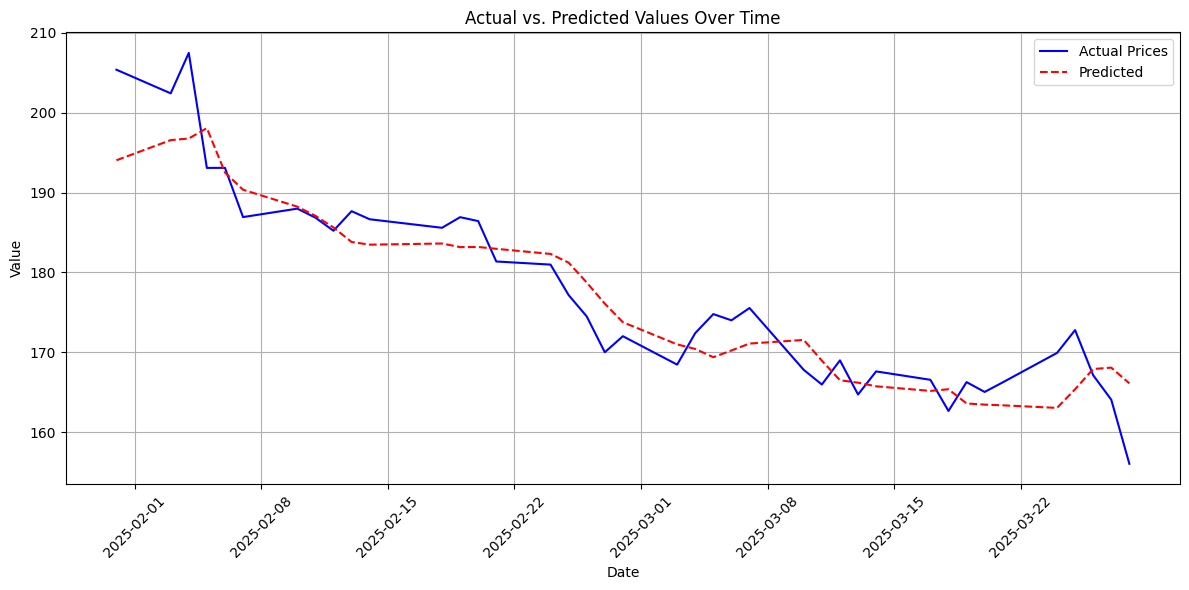

In [54]:
plot_dates = original_indices_for_y[-len(predictions):]
actual_values = y_test_actual
predicted_values = predictions

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, actual_values, label="Actual Prices", color='blue')
plt.plot(plot_dates, predicted_values, label='Predicted', color='red', linestyle='dashed')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### SARIMA

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
training_data = list(prices['Close'])

In [58]:
modelpredictions=[]
for i in range(len(actual)):
  model = SARIMAX(training_data, order=(0,1,2), seasonal_order=(2,1,0,12))
  model_fit = model.fit()
  forecast = model_fit.forecast()
  yhat = list(forecast)[0]
  modelpredictions.append(yhat)
  actual_test = list(actual['Close'])[i]
  training_data.append(actual_test)

In [59]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1316
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood               -3174.493
Date:                             Fri, 11 Apr 2025   AIC                           6358.987
Time:                                     06:24:47   BIC                           6384.849
Sample:                                          0   HQIC                          6368.689
                                            - 1316                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0565      0.024     -2.367      0.018      -0.103      -0.010
ma.L2         -0.0015      

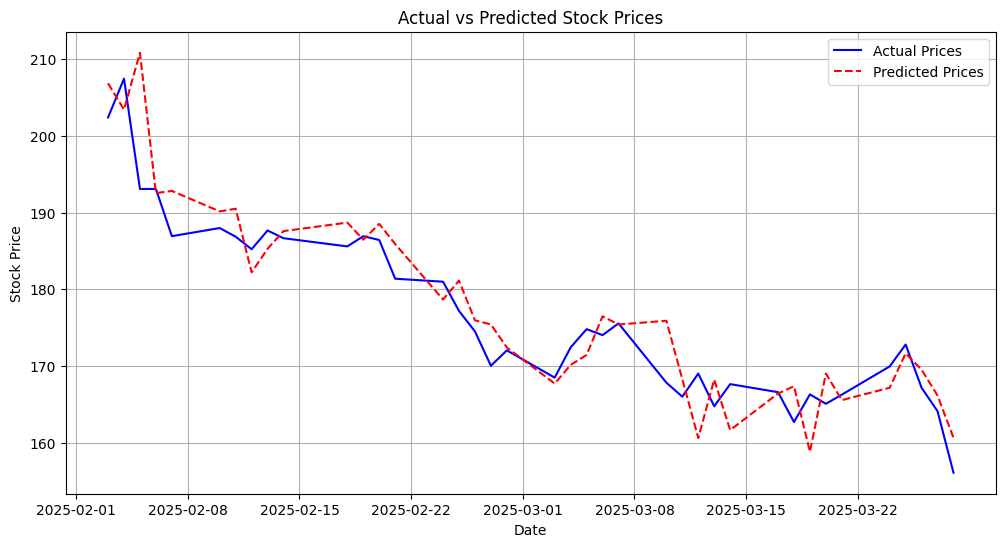

In [60]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [61]:
rmse = np.sqrt(mean_squared_error(actual['Close'], modelpredictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 4.6801


In [62]:
r2_score(actual['Close'], modelpredictions)

0.8334767455380475

### Prophet

In [63]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.2 MB/s eta 0:00:00


In [64]:

import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

##


In [65]:
train_df = df[['Date', 'Close', 'Volume']]
train_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [66]:
test_df = actual[['Date', 'Close', 'Volume']]
test_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [67]:
train_sub, val_sub= train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)


In [68]:
len(train_sub), len(val_sub), len(test_df)

(1022, 256, 39)

In [69]:
train_df

,ds,y,Volume
0,2020-01-02,68.046196,28132000
1,2020-01-03,67.712273,23728000
2,2020-01-06,69.381874,34646000
3,2020-01-07,69.338585,30054000
4,2020-01-08,69.884987,30560000
...,...,...,...
1273,2025-01-27,193.549500,24970200
1274,2025-01-28,196.845749,15939200
1275,2025-01-29,196.955612,12287800
1276,2025-01-30,202.399414,14571500


In [70]:
from prophet.diagnostics import cross_validation, performance_metrics


def objective(trial):
    # Hyperparameters to tune
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.01, 10.0, log=True)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 0.01, 10.0, log=True)

    # Build the Prophet model
    model = Prophet(
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
    )

    # Add extra regressors
    model.add_regressor('Volume')
    # train_sub, valsub= train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)

    # Fit on the train_sub
    model.fit(train_df)

    df_cv = cross_validation(
        model=model,
        initial='730 days',   # e.g., use ~2 years of data before first cutoff
        horizon='90 days',    # e.g., 3-month forecast horizon
        period='90 days'      # new fold every 3 months
    )

    # Predict on val_sub
    df_metrics = performance_metrics(df_cv, rolling_window=1)
    rmse_cv = df_metrics['rmse'].values[0]  # We'll optimize for RMSE

    return rmse_cv

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)  # Increase n_trials for more thorough search


[I 2025-04-11 06:24:51,197] A new study created in memory with name: no-name-81dc0f9b-1675-476d-b90e-a916819e498d
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/zzc_vij6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/fueyh5yd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49730', 'data', 'file=/tmp/tmpbj33azhk/zzc_vij6.json', 'init=/tmp/tmpbj33azhk/fueyh5yd.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelam8ht9ez/prophet_model-20250411062452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forec

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/l27i5zsj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/5umazi3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75050', 'data', 'file=/tmp/tmpbj33azhk/l27i5zsj.json', 'init=/tmp/tmpbj33azhk/5umazi3q.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelhmx2x4nc/prophet_model-20250411062455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cx4_45ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/jznazbme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/oi4wvuqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ae093b5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20773', 'data', 'file=/tmp/tmpbj33azhk/oi4wvuqj.json', 'init=/tmp/tmpbj33azhk/ae093b5a.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model4crojujp/prophet_model-20250411062518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/sz7ojsug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/uswxay9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/gx20u11w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/w5qf3ms5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29361', 'data', 'file=/tmp/tmpbj33azhk/gx20u11w.json', 'init=/tmp/tmpbj33azhk/w5qf3ms5.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelrkng82yt/prophet_model-20250411062534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:25:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ezuk40e8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/f1f8yjls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/atht9t8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/y0whteb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44529', 'data', 'file=/tmp/tmpbj33azhk/atht9t8k.json', 'init=/tmp/tmpbj33azhk/y0whteb1.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelqkuezkmk/prophet_model-20250411062548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/2jhfr3im.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/chcj3mix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/xmgseelx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ks162wno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97616', 'data', 'file=/tmp/tmpbj33azhk/xmgseelx.json', 'init=/tmp/tmpbj33azhk/ks162wno.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modela03trr7j/prophet_model-20250411062604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wip8lok0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/f4eimh_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cnqh19ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cqfs_mhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58847', 'data', 'file=/tmp/tmpbj33azhk/cnqh19ml.json', 'init=/tmp/tmpbj33azhk/cqfs_mhq.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelvix768w3/prophet_model-20250411062615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/4jt5zdta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/q26qg6kn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/04p8gw8i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/pi6bkpzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16421', 'data', 'file=/tmp/tmpbj33azhk/04p8gw8i.json', 'init=/tmp/tmpbj33azhk/pi6bkpzy.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelpl5cogt6/prophet_model-20250411062628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wwjv9jkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ta_ym8_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/_0ql3k78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/2odvighi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34610', 'data', 'file=/tmp/tmpbj33azhk/_0ql3k78.json', 'init=/tmp/tmpbj33azhk/2odvighi.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model5n7ifz3j/prophet_model-20250411062641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/941u18ig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/jhpvf5dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/916dk9ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/21htm2d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13954', 'data', 'file=/tmp/tmpbj33azhk/916dk9ud.json', 'init=/tmp/tmpbj33azhk/21htm2d0.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model2svkhk69/prophet_model-20250411062653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/2vap8mfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/7sxkx88k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/vh2iofyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/65a1gya0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73608', 'data', 'file=/tmp/tmpbj33azhk/vh2iofyh.json', 'init=/tmp/tmpbj33azhk/65a1gya0.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model45vtad5d/prophet_model-20250411062710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/lhzeis1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/uogp9xb9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/0s8eshlh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/jjwqcn8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63785', 'data', 'file=/tmp/tmpbj33azhk/0s8eshlh.json', 'init=/tmp/tmpbj33azhk/jjwqcn8d.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modeljtilwh95/prophet_model-20250411062721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/k82igrqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/23kggek6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/3qlpwg7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/njl1zzfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81234', 'data', 'file=/tmp/tmpbj33azhk/3qlpwg7u.json', 'init=/tmp/tmpbj33azhk/njl1zzfh.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model70c7st_5/prophet_model-20250411062735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/gbf0w1d3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/iu0t7qxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/4n9fz55w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ekuc3_x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64387', 'data', 'file=/tmp/tmpbj33azhk/4n9fz55w.json', 'init=/tmp/tmpbj33azhk/ekuc3_x8.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model0c5goox_/prophet_model-20250411062748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/c_hj1453.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/18pm3zxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/e_x_amqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/p3cjf4fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11849', 'data', 'file=/tmp/tmpbj33azhk/e_x_amqo.json', 'init=/tmp/tmpbj33azhk/p3cjf4fe.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model2r62yuwm/prophet_model-20250411062801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/un52zbye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/u75ckt5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/yuk1qk1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/0c1giv1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92093', 'data', 'file=/tmp/tmpbj33azhk/yuk1qk1a.json', 'init=/tmp/tmpbj33azhk/0c1giv1m.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_models0ncb3ov/prophet_model-20250411062813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/kvsnoerv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/hpeo8pmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wponl8i8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ia6v4ybe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92615', 'data', 'file=/tmp/tmpbj33azhk/wponl8i8.json', 'init=/tmp/tmpbj33azhk/ia6v4ybe.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelzk5hh3ow/prophet_model-20250411062819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/if18zznm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ygjgfrwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/chzs9qwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cz0rojhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23114', 'data', 'file=/tmp/tmpbj33azhk/chzs9qwh.json', 'init=/tmp/tmpbj33azhk/cz0rojhp.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelis9mtu7i/prophet_model-20250411062831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/sj3s0aje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/0pkstuau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/a4o2erdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ovr9yfuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64818', 'data', 'file=/tmp/tmpbj33azhk/a4o2erdw.json', 'init=/tmp/tmpbj33azhk/ovr9yfuj.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model1hr54ct9/prophet_model-20250411062842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/yy2b5ynb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ww0z0ugr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/93riz_n1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cogg8x5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37624', 'data', 'file=/tmp/tmpbj33azhk/93riz_n1.json', 'init=/tmp/tmpbj33azhk/cogg8x5s.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelzsx67uaa/prophet_model-20250411062853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/1mw9ipau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ohm54ltl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/e3sc4fye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/jq4w0pyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91670', 'data', 'file=/tmp/tmpbj33azhk/e3sc4fye.json', 'init=/tmp/tmpbj33azhk/jq4w0pyd.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model5uysav_m/prophet_model-20250411062902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ri8zfxbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/gda56wdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/c08vwpua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/xetjwj6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5245', 'data', 'file=/tmp/tmpbj33azhk/c08vwpua.json', 'init=/tmp/tmpbj33azhk/xetjwj6n.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modeljbrcz7ml/prophet_model-20250411062914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/b0oqej_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/mypc6v7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ltq5wuxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/af5gdddq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26078', 'data', 'file=/tmp/tmpbj33azhk/ltq5wuxv.json', 'init=/tmp/tmpbj33azhk/af5gdddq.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelwrhcve2r/prophet_model-20250411062928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/sr6yszqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/l0hdvqye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/z5z62gqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ow1l91gg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73663', 'data', 'file=/tmp/tmpbj33azhk/z5z62gqx.json', 'init=/tmp/tmpbj33azhk/ow1l91gg.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model49t7kxqa/prophet_model-20250411062941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/09z86l29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wmqyy0bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/jpral629.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/5l029mhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47370', 'data', 'file=/tmp/tmpbj33azhk/jpral629.json', 'init=/tmp/tmpbj33azhk/5l029mhl.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modeljn2easxn/prophet_model-20250411062953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ki41wwns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/skl0rhxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/yktp9rlf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/lvs8w2x0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80757', 'data', 'file=/tmp/tmpbj33azhk/yktp9rlf.json', 'init=/tmp/tmpbj33azhk/lvs8w2x0.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelluudwn9a/prophet_model-20250411063005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cosc8e0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/14et8awu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/6pvc7lf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/x5y7np7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61580', 'data', 'file=/tmp/tmpbj33azhk/6pvc7lf9.json', 'init=/tmp/tmpbj33azhk/x5y7np7i.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelc0ebu9hl/prophet_model-20250411063018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/4lqm9eq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/_w2kw1fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/6xt7s_p6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/g7x8h4pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82283', 'data', 'file=/tmp/tmpbj33azhk/6xt7s_p6.json', 'init=/tmp/tmpbj33azhk/g7x8h4pu.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelafwkgyh9/prophet_model-20250411063031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/t3wvco9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/9px6t7jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/56bgtca7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/el_tkqqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19059', 'data', 'file=/tmp/tmpbj33azhk/56bgtca7.json', 'init=/tmp/tmpbj33azhk/el_tkqqd.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelmfkwktsa/prophet_model-20250411063045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/lgksdzmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/akaebhyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/nqz87_x2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/mh_dn90t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54199', 'data', 'file=/tmp/tmpbj33azhk/nqz87_x2.json', 'init=/tmp/tmpbj33azhk/mh_dn90t.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model1wgk0deh/prophet_model-20250411063057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/cw9qzerj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/esmoknkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/frqlgoqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/w_v18g3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64554', 'data', 'file=/tmp/tmpbj33azhk/frqlgoqc.json', 'init=/tmp/tmpbj33azhk/w_v18g3j.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelod7v_eza/prophet_model-20250411063110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/a7dttpsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/kn6t5owb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/mnoz7rwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/9re3owcm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6534', 'data', 'file=/tmp/tmpbj33azhk/mnoz7rwd.json', 'init=/tmp/tmpbj33azhk/9re3owcm.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modell41kyc8_/prophet_model-20250411063122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/igcgm8pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/pdvywwm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ft9_x7a7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/lc0_75mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42409', 'data', 'file=/tmp/tmpbj33azhk/ft9_x7a7.json', 'init=/tmp/tmpbj33azhk/lc0_75mi.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelo96nzjwi/prophet_model-20250411063130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/8ba2jcs0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ftbuzxbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/gp9qonav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/56x3m4he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12041', 'data', 'file=/tmp/tmpbj33azhk/gp9qonav.json', 'init=/tmp/tmpbj33azhk/56x3m4he.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelc091fvdp/prophet_model-20250411063143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/9ohqzmz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/mnrfbayd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/95kb5gvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/gtbbz2ct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83390', 'data', 'file=/tmp/tmpbj33azhk/95kb5gvo.json', 'init=/tmp/tmpbj33azhk/gtbbz2ct.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model4xxr8w2d/prophet_model-20250411063156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/nvnxavsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/y9eaq9ar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/m_4nt2uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/sd4jpc4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88987', 'data', 'file=/tmp/tmpbj33azhk/m_4nt2uj.json', 'init=/tmp/tmpbj33azhk/sd4jpc4i.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelddm8h85_/prophet_model-20250411063209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/p8bhseoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/6c2oan1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ayelaxj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/3kd5g6jc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1921', 'data', 'file=/tmp/tmpbj33azhk/ayelaxj_.json', 'init=/tmp/tmpbj33azhk/3kd5g6jc.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelgoowy4bg/prophet_model-20250411063223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/rkg3kxqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/454mcatp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/4lxb55v8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/w0sdn3f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20616', 'data', 'file=/tmp/tmpbj33azhk/4lxb55v8.json', 'init=/tmp/tmpbj33azhk/w0sdn3f0.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modeled93gf74/prophet_model-20250411063234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/x2gyhuuy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/pru5wvic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ca3yccup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/vetkf7pn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1156', 'data', 'file=/tmp/tmpbj33azhk/ca3yccup.json', 'init=/tmp/tmpbj33azhk/vetkf7pn.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelhm5y1n7w/prophet_model-20250411063247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/feywz6q_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wnyy9axh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/b9859wbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/vz_ah5z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88343', 'data', 'file=/tmp/tmpbj33azhk/b9859wbi.json', 'init=/tmp/tmpbj33azhk/vz_ah5z4.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelzgoa0qa3/prophet_model-20250411063300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/d4_q__yq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/spej_dnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/ws773g1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/_i4ilwyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9172', 'data', 'file=/tmp/tmpbj33azhk/ws773g1c.json', 'init=/tmp/tmpbj33azhk/_i4ilwyc.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelcwnf3oit/prophet_model-20250411063312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/wadsx0ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/u_3qnzdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [71]:
best_trial = study.best_trial
print("Best trial RMSE (Val):", best_trial.value)
print("Best trial params:", best_trial.params)


Best trial RMSE (Val): 11.111015534332115
Best trial params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.6160318586938105, 'seasonality_prior_scale': 0.013613460675216254, 'holidays_prior_scale': 0.953489162686782}


In [72]:
best_params = study.best_params

final_model = Prophet(
    seasonality_mode=best_params["seasonality_mode"],
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    holidays_prior_scale=best_params["holidays_prior_scale"]
)
final_model.add_regressor('Volume')
final_model.fit(train_df)

df_cv_final = cross_validation(
    model=final_model,
    initial='730 days',
    horizon='90 days',
    period='90 days'
)
df_metrics_final = performance_metrics(df_cv_final, rolling_window=1)

print("\n=== Final Model cross_validation Metrics ===")
print(df_metrics_final[['mse','rmse','mae','mape']].head())




future_test = test_df[['ds','Volume']]
forecast_test = final_model.predict(future_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/kazr1p8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/h51t6oyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50962', 'data', 'file=/tmp/tmpbj33azhk/kazr1p8t.json', 'init=/tmp/tmpbj33azhk/h51t6oyp.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_modelpq9on2ur/prophet_model-20250411063323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2022-02-16 00:00:00 and 2024-11-02 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/iuff4bfj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/76pobmkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97867', 'data', 'file=/tmp/tmpbj33azhk/iuff4bfj.json', 'init=/tmp/tmpbj33azhk/76pobmkk.json', 'output', 'file=/tmp/tmpbj33azhk/prophet_model1q3ec46b/prophet_model-20250411063324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/l75xnri3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj33azhk/xjhib7k3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


=== Final Model cross_validation Metrics ===
          mse       rmse       mae      mape
0  123.454666  11.111016  9.222778  0.072946


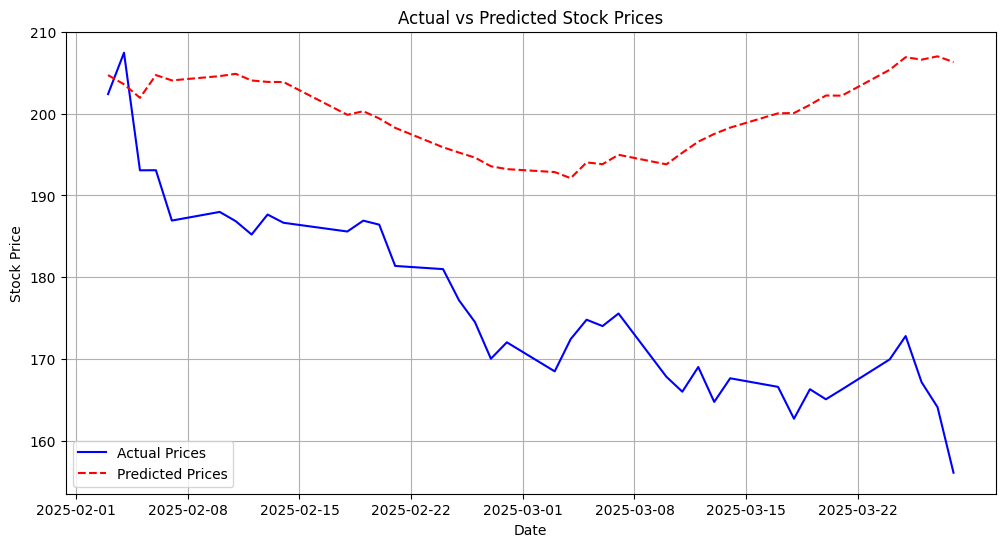

In [73]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], forecast_test['yhat'], label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### SVM

In [76]:
# prompt: import GridSearchCV

from sklearn.model_selection import GridSearchCV
# ... (your existing code) ...


In [79]:
# Define features and target
features = ['High', 'Low', 'Open', 'Volume']
target = 'Close'

# Split the data into training (80%) and testing (20%) sets
train_features = df[features].values
train_target = df[target].values
test_features = actual[features].values
test_target = actual[target].values # You might need this later

# Standardize the predictors
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Adjusted hyperparameter grid to prevent overfitting
param_grid = {
    'C': [0.01, 0.1],
    'epsilon': [0.1, 0.2],
    'gamma': ['scale'],
    'kernel': ['linear']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train_scaled, train_target)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the SVR model with the best parameters
svm_model = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_model.fit(train_scaled, train_target)

# Predict on the testing set
test_preds = svm_model.predict(test_scaled)

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [81]:

# Calculate R-squared and Mean Squared Error (MSE)
test_r2 = r2_score(test[target], test_preds)
test_mse = mean_squared_error(test[target], test_preds)

print(f"Testing R-squared: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


Testing R-squared: 0.9756
Testing MSE: 3.2125


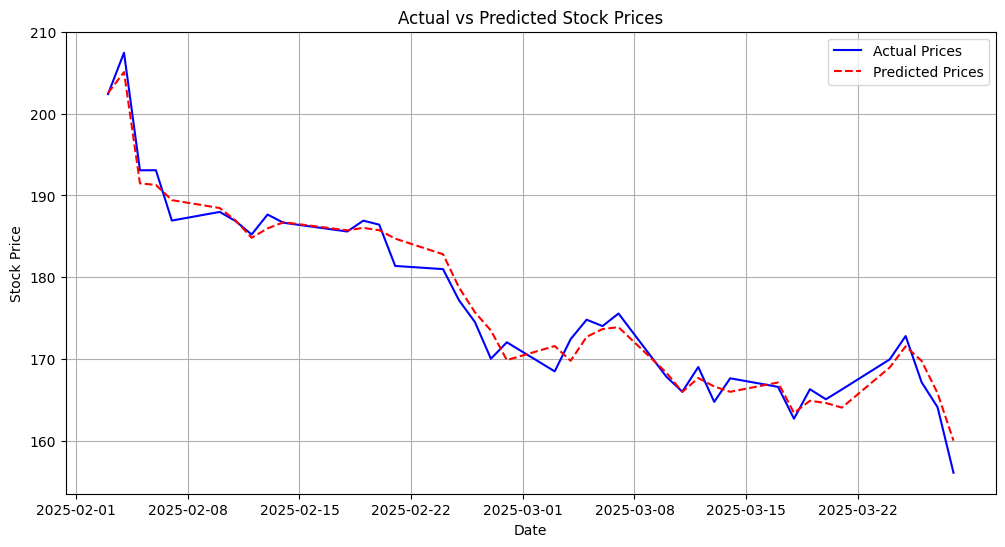

In [82]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], test_preds, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

train, test = df,actual
model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)
predictors = ["Close", "Volume", "Open", "High", "Low"]
predictions = []

for i in range(len(test)):

    # Retrain the model with the updated training data
    model.fit(train[predictors], train["Close"])

    # Predict the next value
    next_pred = model.predict(test.iloc[[i]][predictors])[0]
    predictions.append(next_pred)

    # Create a new row with the predicted value and the corresponding test data
    new_row = test.iloc[[i]].copy()
    new_row['Close'] = next_pred

    # Add the new row to the training data
    train = pd.concat([train, new_row], ignore_index=True)

print("Predictions:", predictions)

Predictions: [np.float64(190.356822306355), np.float64(190.36809642673836), np.float64(190.39660940421462), np.float64(190.42207377295682), np.float64(190.46138283917216), np.float64(190.50446164483517), np.float64(190.52508843855628), np.float64(190.58212156975117), np.float64(190.64173410875512), np.float64(190.6879349416188), np.float64(190.7169687813036), np.float64(190.75630410884673), np.float64(190.75862204898812), np.float64(190.7745978310483), np.float64(188.54462501568278), np.float64(169.8062502476869), np.float64(168.7740732088301), np.float64(168.830853579859), np.float64(168.82423315518125), np.float64(168.68974062958114), np.float64(168.96799098168202), np.float64(169.13888243840313), np.float64(169.20627938204788), np.float64(169.57919521678815), np.float64(168.2918692829286), np.float64(167.6399169712981), np.float64(168.6250842211683), np.float64(167.41083157485573), np.float64(168.20971199209814), np.float64(167.5248401043674), np.float64(166.99010167125246), np.floa

In [84]:
# Calculate R-squared and Mean Squared Error (MSE)
test_r2 = r2_score(test[target], predictions)

test_mse = mean_squared_error(test[target], predictions)

print(f"Testing R-squared: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R-squared: 0.8085
Testing MSE: 25.1943


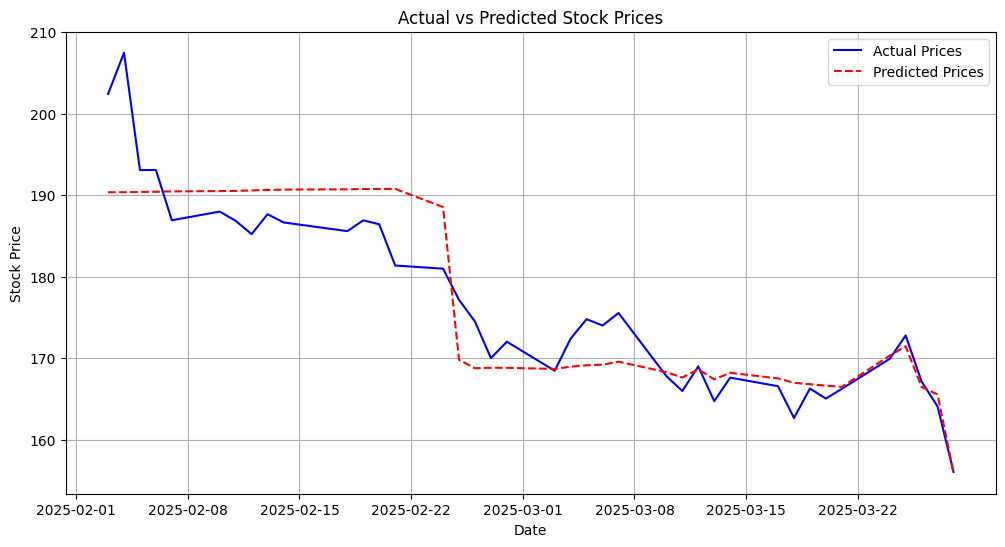

In [85]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], predictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### Metrics

| Ratio                     | R2     | MSE                          |RMSE|
|--------------------------|-----------||--------------------------------------------|
| ARIMA        |0.873728320419118| |4.0754|
| SARIMA   |0.8334767462536443|||
| PROPHET| |||
|Random Forest |0.8085|25.1943||
|SVM|0.9756|3.2125||
|LSTM||0.000380886864149943||

---